In [ ]:
!pip install pyspark py4j handyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
from handyspark import *
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
spark = SparkSession.builder.master("local").appName("LogReg").getOrCreate()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving heart_indicators.csv to heart_indicators.csv


In [ ]:
heart_df = spark.read \
    .option("inferSchema",True) \
    .option("sep",",") \
    .option("header",True)\
    .csv("heart_indicators.csv")

In [ ]:
heart_df.show(10)

+--------------------+------+--------+---------+----+------+------+--------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|HeartDiseaseorAttack|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|Diabetes|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+--------------------+------+--------+---------+----+------+------+--------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|                 0.0|   1.0|     1.0|      1.0|40.0|   1.0|   0.0|     0.0|         0.0|   0.0|    1.0|              0.0|          1.0|        0.0|    5.0|    18.0|    15.0|     1.0|0.0| 9.0|      4.0|   3.0|
|                 0.0|   0.0|     0.0|      0.0|25.0|   1.0|   0.0|     0.0|         1.0|   0.0|    0.0|              0.0|          0.0|        1.0|    3.0|    

In [ ]:
# describing the data
display(heart_df.describe())
print('rows after dropping NAs'), heart_df.dropna().count()
print('rows in the data') , heart_df.count()


DataFrame[summary: string, HeartDiseaseorAttack: string, HighBP: string, HighChol: string, CholCheck: string, BMI: string, Smoker: string, Stroke: string, Diabetes: string, PhysActivity: string, Fruits: string, Veggies: string, HvyAlcoholConsump: string, AnyHealthcare: string, NoDocbcCost: string, GenHlth: string, MentHlth: string, PhysHlth: string, DiffWalk: string, Sex: string, Age: string, Education: string, Income: string]

rows after dropping NAs
rows in the data


(None, 253680)

In [ ]:
# dropping rows due to lack of usefulness for the study

heart_df = heart_df.drop('PhysActivity','Fruits','NoDocbcCost','AnyHealthcare', 
                                            'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'Income',
                                            'MentHlth', 'PhysHlth', 'DiffWalk', 'CholCheck', 'Education')

In [ ]:
# 1 is male, 0 is female

heart_df.show(10)

+--------------------+------+--------+----+------+------+--------+---+----+
|HeartDiseaseorAttack|HighBP|HighChol| BMI|Smoker|Stroke|Diabetes|Sex| Age|
+--------------------+------+--------+----+------+------+--------+---+----+
|                 0.0|   1.0|     1.0|40.0|   1.0|   0.0|     0.0|0.0| 9.0|
|                 0.0|   0.0|     0.0|25.0|   1.0|   0.0|     0.0|0.0| 7.0|
|                 0.0|   1.0|     1.0|28.0|   0.0|   0.0|     0.0|0.0| 9.0|
|                 0.0|   1.0|     0.0|27.0|   0.0|   0.0|     0.0|0.0|11.0|
|                 0.0|   1.0|     1.0|24.0|   0.0|   0.0|     0.0|0.0|11.0|
|                 0.0|   1.0|     1.0|25.0|   1.0|   0.0|     0.0|1.0|10.0|
|                 0.0|   1.0|     0.0|30.0|   1.0|   0.0|     0.0|0.0| 9.0|
|                 0.0|   1.0|     1.0|25.0|   1.0|   0.0|     0.0|0.0|11.0|
|                 1.0|   1.0|     1.0|30.0|   1.0|   0.0|     2.0|0.0| 9.0|
|                 0.0|   0.0|     0.0|24.0|   0.0|   0.0|     0.0|1.0| 8.0|
+-----------

In [ ]:
heart_df.dtypes

[('HeartDiseaseorAttack', 'double'),
 ('HighBP', 'double'),
 ('HighChol', 'double'),
 ('BMI', 'double'),
 ('Smoker', 'double'),
 ('Stroke', 'double'),
 ('Diabetes', 'double'),
 ('Sex', 'double'),
 ('Age', 'double')]

In [ ]:
#converting Non-Diabetic, Type 1 and Type 2 diabetes into a single binary diabetes variable 

heart_df.withColumn('Diabetes', when(heart_df.Diabetes == '0.0',heart_df.Diabetes).otherwise(1.0)).show()

heart_df = heart_df.withColumn("Diabetes", when(heart_df.Diabetes == 0, 0) \
          .when(heart_df.Diabetes == 1, 1) \
      .when(heart_df.Diabetes ==2, 1))

+--------------------+------+--------+----+------+------+--------+---+----+
|HeartDiseaseorAttack|HighBP|HighChol| BMI|Smoker|Stroke|Diabetes|Sex| Age|
+--------------------+------+--------+----+------+------+--------+---+----+
|                 0.0|   1.0|     1.0|40.0|   1.0|   0.0|     0.0|0.0| 9.0|
|                 0.0|   0.0|     0.0|25.0|   1.0|   0.0|     0.0|0.0| 7.0|
|                 0.0|   1.0|     1.0|28.0|   0.0|   0.0|     0.0|0.0| 9.0|
|                 0.0|   1.0|     0.0|27.0|   0.0|   0.0|     0.0|0.0|11.0|
|                 0.0|   1.0|     1.0|24.0|   0.0|   0.0|     0.0|0.0|11.0|
|                 0.0|   1.0|     1.0|25.0|   1.0|   0.0|     0.0|1.0|10.0|
|                 0.0|   1.0|     0.0|30.0|   1.0|   0.0|     0.0|0.0| 9.0|
|                 0.0|   1.0|     1.0|25.0|   1.0|   0.0|     0.0|0.0|11.0|
|                 1.0|   1.0|     1.0|30.0|   1.0|   0.0|     1.0|0.0| 9.0|
|                 0.0|   0.0|     0.0|24.0|   0.0|   0.0|     0.0|1.0| 8.0|
|           

In [ ]:
#converting to integers 

cols = [col(field[0]).cast('int') if field[1] == 'double' else col(field[0]) for field in heart_df.dtypes]
heart_df = heart_df.select(cols)

In [ ]:
# splitting into train and test sets


train, test = heart_df.randomSplit([0.8,0.2], seed=1)

In [ ]:
train.count()
test.count()

50785

In [ ]:
#creating the features column
feature_cols = [x for (x, dataType) in train.dtypes if x != 'HeartDiseaseorAttack']
print(feature_cols)

['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'Sex', 'Age']


In [ ]:
#creating a balanced weight column 
balancingRatio = train.filter(col('HeartDiseaseorAttack') == 1).count() / train.count()

calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())

train = train.withColumn('classWeightCol', calculateWeights('HeartDiseaseorAttack'))

In [ ]:
train.show()

+--------------------+------+--------+---+------+------+--------+---+---+-------------------+
|HeartDiseaseorAttack|HighBP|HighChol|BMI|Smoker|Stroke|Diabetes|Sex|Age|     classWeightCol|
+--------------------+------+--------+---+------+------+--------+---+---+-------------------+
|                   0|     0|       0| 12|     0|     0|       0|  0|  7|0.09397471598610119|
|                   0|     0|       0| 12|     0|     0|       0|  0| 13|0.09397471598610119|
|                   0|     0|       0| 12|     0|     0|       0|  1|  9|0.09397471598610119|
|                   0|     0|       0| 12|     1|     0|       0|  1|  6|0.09397471598610119|
|                   0|     0|       0| 13|     0|     0|       0|  0|  6|0.09397471598610119|
|                   0|     0|       0| 13|     0|     0|       0|  0|  7|0.09397471598610119|
|                   0|     0|       0| 13|     0|     0|       0|  0|  9|0.09397471598610119|
|                   0|     0|       0| 13|     0|     0|    

In [ ]:
# using a pipeline
vectorAssembler = VectorAssembler(inputCols=feature_cols, outputCol="unscaled_features")
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

lr = LogisticRegression(
    maxIter=50,
    featuresCol = "features",
    labelCol = "HeartDiseaseorAttack",
    weightCol='classWeightCol'
)

estimators = [vectorAssembler, standardScaler, lr]

In [ ]:
# building the model using the pipeline

pipeline = Pipeline(stages=estimators)

# model = pipeline.fit(train)

In [ ]:
# paramgrid of 3x3 = 9 total models to itterate over

paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0] ) \
    .addGrid(lr.regParam, [0.1, 0.01, 0]) \
    .build()

#trying 5 folds
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='HeartDiseaseorAttack'),
                          numFolds=5)  

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

# cv model then uses the best model for predictions
prediction = cvModel.transform(test)
prediction_label = prediction.select("HeartDiseaseorAttack", "prediction","probability")

In [ ]:
# evaluate the model
eval = RegressionEvaluator(labelCol="HeartDiseaseorAttack", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(prediction)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(prediction, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(prediction, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(prediction, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 0.524
MSE: 0.274
MAE: 0.274
r2: -2.190


In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="HeartDiseaseorAttack", 
    predictionCol="prediction"
)

# accuracy
acc = evaluator.evaluate(prediction_label, {evaluator.metricName: "accuracy"})
print("Accuracy: {:.3f}".format(acc))

#precision
precision = evaluator.evaluate(prediction_label, {evaluator.metricName: "weightedPrecision"})
print("Weighted Precision: {:.3f}".format(precision))

#recall
recall = evaluator.evaluate(prediction_label, {evaluator.metricName: "weightedRecall"})
print("Weighted Recall: {:.3f}".format(recall))

#f1 score
f1 = evaluator.evaluate(prediction_label, {evaluator.metricName: "f1"})
print("F1 Score: {:.3f}".format(f1))

#log loss score
logloss = evaluator.evaluate(prediction_label, {evaluator.metricName: "logLoss"})
print("Log Loss: {:.3f}".format(logloss))

Accuracy: 0.726
Weighted Precision: 0.896
Weighted Recall: 0.726
F1 Score: 0.781
Log Loss: 0.531


In [ ]:
#Confusion matrix
predlabel = prediction_label.toPandas()
confusion_matrix = pd.crosstab(
    predlabel["HeartDiseaseorAttack"], 
    predlabel["prediction"], 
    rownames=["Actual"], 
    colnames=["Predicted"]
)
confusion_matrix

NameError: ignored

In [ ]:
TN = confusion_matrix[0][0]
FN = confusion_matrix[0][1]
TP = confusion_matrix[1][1]
FP = confusion_matrix[1][0]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print("Sensitivity: {:.3f}\nSpecificity: {:.3f}".format(sensitivity,specificity))

Sensitivity: 0.766
Specificity: 0.721


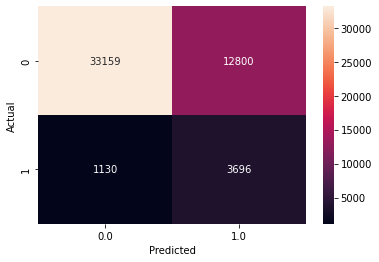

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()
plt.savefig("confusion_matrix.png")

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol='HeartDiseaseorAttack')

# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.8158
Area under PR Curve: 0.3115


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


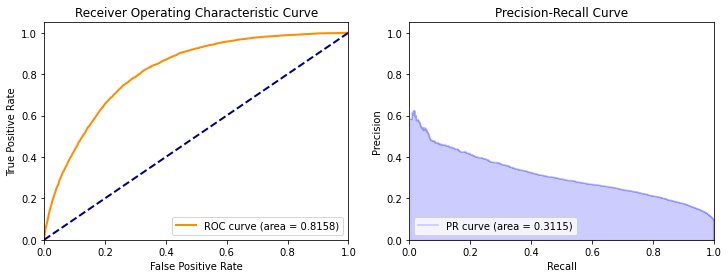

In [ ]:
bcm = BinaryClassificationMetrics(prediction, scoreCol='probability', labelCol='HeartDiseaseorAttack')

#getting the curves and saving them
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])